# H&M Retail Sales Trending Item Prediction - Advanced Modelling

In the previous steps, we've

# Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import warnings
import joblib
from tqdm import tqdm
import time

# Sklearn ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Text Processing
import string
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Imbalance learning
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model Evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loaing Data and Connect to Drive

Here we load the product data with trending labelled in the previous step.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/BrainStation/DS/Capstone/'

In [5]:
# Read the data
prod_df = pd.read_csv(path+'data/prod_df.csv')

# Advanced ML Modelling

Using the baseline models and model evaluation strategy you built in the previous part, we will springboard into advanced model building, optimization, evaluation and interpretation. Here are the steps:
- Create a pipeline for tokenization, scaling, and imbalanced learning
- Implement the pipeline for hyperparameter optimization with baseline model
- Apply the methods to other ML models

## Pipeline

For efficiency purposes and reusability, here we want to wrap up all our feature engineering steps and modelling with column transformer and pipelines.

**First, we need to retrieve our tokenizer**

In [6]:
# Custom tokenizer using lemmatizing
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


lemmatizer = WordNetLemmatizer()

ENGLISH_STOP_WORDS = stopwords.words('english')
# Include words we want to clean in stop words
ENGLISH_STOP_WORDS.extend(['none','no', 'nothing','n','a','negative','positive'])

def my_lemma_tokenizer(sentence):
    # # remove punctuation, numbers, and set to lower case
    # sentence = re.sub(r'[^a-zA-Z\s]', '', sentence).lower()

    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    pos_tags = nltk.pos_tag(listofwords)
    listoflemmatized_words = []

    # remove stopwords and any tokens that are just empty strings
    for word, tag in pos_tags:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Lemmatized words

            lemmatized_word = lemmatizer.lemmatize(word,get_wordnet_pos(tag))
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words

**Next, we can use pipeline to wrap all the steps together**  
- TfidfVectorizer
- StandardScaler
- OneHotEncoder
- SMOTE Upsamping
- ML model

**Train Test Split**

In [7]:
# Spliting features X and target y
X = prod_df.drop(['trending', 'product_id'], axis=1)
y = prod_df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

(28962, 8) (7241, 8)


**Custom Function to add in Pipeline using Function Transformer**

In [8]:
# Custom function to convert sparse matrix to dense array
def to_dense(X):
    return X.toarray()

**Defining Pipeline Function**

In [9]:
def hm_pipeline(model):
    """
    Create an imbalanced-learn pipeline for text and categorical feature processing,
    applying Synthetic Minority Over-sampling Technique (SMOTE), and a specified model.

    Parameters:
    - model: The classification model to be used in the pipeline.

    Returns:
    - ImbPipeline: An imbalanced-learn pipeline that includes text and categorical feature processing,
      SMOTE for dealing with class imbalance, and the specified classification model.

    Example:
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> from imblearn.pipeline import Pipeline as ImbPipeline
    >>> model = RandomForestClassifier()
    >>> pipeline = hm_pipeline(model)
    >>> pipeline.fit(X_train, y_train)
    >>> y_pred = pipeline.predict(X_test)
    """
    # Columns for one-hot encoding
    categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']

    # Create the column transformations list + columns to which to apply
    col_transforms = [('desc', TfidfVectorizer(max_features=500, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'detail_desc'),
                      ('name', TfidfVectorizer(max_features=500, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'prod_name'),
                      ('normalise', StandardScaler(), ['unit_price']),
                      ('cat', OneHotEncoder(drop='first'), categorical_columns)
                     ]

    # Create the column transformer
    col_trans = ColumnTransformer(col_transforms)

    # List of estimators in the pipeline
    estimators = [('preprocessor', col_trans),
                  ('to_dense', FunctionTransformer(func=to_dense, validate=False)),
                  ('smote', SMOTE(random_state=123)),
                  ('clf', model)
                 ]

    # Create and return the imbalanced-learn pipeline
    return ImbPipeline(estimators)

**Testing out the pipeline with Logistic Regression Model**

In [12]:
# Specify the model for the pipeline
model_params = {'random_state':123}
model = LogisticRegression(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Fitting the pipeline with training data
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.80      0.88      6475
        True       0.32      0.81      0.46       766

    accuracy                           0.80      7241
   macro avg       0.65      0.80      0.67      7241
weighted avg       0.90      0.80      0.83      7241



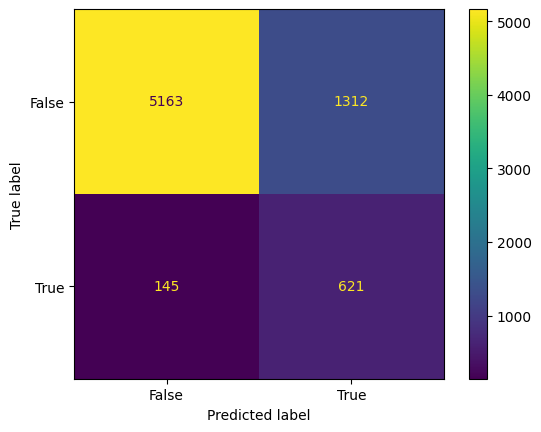

In [10]:
# Evaluate with confusion matrix
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
plt.show()

Here we can see that we have a slightly higher recall score (**81%**). That might be due to the order difference of our steps (putting standard scaler before one-hot encoder).

**For model comparison, we also want to create a function that calculates our desired evaluation metrics**

In [13]:
def calculate_metrics(model_name, model_params, y_true, y_pred):
    """
    Calculate precision, recall, F1 score, accuracy, and false positive rate.

    Parameters:
    - y_true: true labels
    - y_pred: predicted labels
    - model_name: name of the classification model
    - model_params: dictionary containing the model parameters

    Returns:
    - metrics_dict: a dictionary containing precision, recall, f1_score, accuracy, false_positive_rate,
      model_name, and model_params
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate true positives, false positives, false negatives, true negatives
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tn = cm[0, 0]

    # Calculate precision, recall, F1 score, accuracy, and false positive rate
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    false_positive_rate = fp / (fp + tn) if (fp + tn) != 0 else 0.0

    # Create a dictionary to store the metrics and model specifications
    metrics_dict = {
        'model_name': model_name,
        'model_params': model_params,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'false_positive_rate': false_positive_rate
    }

    return metrics_dict

**Model Evaluation**

We used the created custom function to pass the model results into a dataframe for easy comparison.

In [14]:
# Extract model specifications
model_name = 'LogisticRegression'
model_params = pipe.named_steps['clf'].get_params()

# Calculate metrics and include model specifications
metrics_dict = calculate_metrics(model_name, model_params, y_test, y_pred)

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])

# Reorder columns to have model_name and model_params at the front
columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
metrics_df = metrics_df[columns_order]

# Display the resulting DataFrame
metrics_df

,model_name,model_params,precision,recall,f1_score,accuracy,false_positive_rate
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.321262,0.810705,0.46017,0.798785,0.202625


**Hyperparmater optimization with our baseline model - Using pipeline and custom evaluation function**

Looping through different Cs and store results

In [14]:
# Empty dataframe to store results
all_metrics_df = pd.DataFrame()

# For loop through different C's for logistic regression
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
for c in tqdm(Cs, desc="Looping through Cs", position=0, leave=True):
    # Specify the model for the pipeline
    model_name = 'LogisticRegression'
    model_params = {'C':c, 'random_state':123}
    model = LogisticRegression(**model_params)

    # Instantiate pipeline with our custom function
    pipe = hm_pipeline(model)

    # Fitting the pipeline with training data
    pipe.fit(X_train, y_train)

    # Predicting with test data
    y_pred = pipe.predict(X_test)

    # Calculate metrics and include model specifications
    metrics_dict = calculate_metrics(model_name, model_params, y_test, y_pred)

    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame([metrics_dict])

    # Reorder columns to have model_name and model_params at the front
    columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
    metrics_df = metrics_df[columns_order]

    # Append the metrics_df to the all_metrics_df
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the resulting DataFrame
all_metrics_df

Looping through Cs: 100%|██████████| 6/6 [07:04<00:00, 70.79s/it]


,model_name,model_params,precision,recall,f1_score,accuracy,false_positive_rate
0,LogisticRegression,"{'C': 0.001, 'random_state': 123}",0.257201,0.827676,0.392448,0.728905,0.282780
1,LogisticRegression,"{'C': 0.01, 'random_state': 123}",0.271296,0.877285,0.414431,0.737743,0.278764
2,LogisticRegression,"{'C': 0.1, 'random_state': 123}",0.299396,0.840731,0.441550,0.775031,0.232741
3,LogisticRegression,"{'C': 1, 'random_state': 123}",0.321262,0.810705,0.460170,0.798785,0.202625
4,LogisticRegression,"{'C': 10, 'random_state': 123}",0.321814,0.778068,0.455309,0.803066,0.193977
5,LogisticRegression,"{'C': 100, 'random_state': 123}",0.322336,0.778068,0.455832,0.803480,0.193514


In [15]:
# saving logreg results
all_metrics_df.to_csv(path+'data/logreg_results.csv', index=False)

Since the goal for this project is to predict trending items, and the data is imbalanced, what we want to optimize is the recall score instead of accuracy. Hence, we might consider the best logistic regression model to be the one with C=0.01, which can identify 87.7% of trending items.

**Next, we can start applying our pipeline on other models**

## SVM

We start with the kernel SVM model here, and loop through different Cs (Regularization Parameter). A smaller C encourages a larger margin and a simpler decision boundary, but may misclassify some points. A larger C gives a lower margin but classifies all training points correctly.

In [ ]:
# For loop through different C's for logistic regression
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
for c in tqdm(Cs, desc="Looping through Cs", position=0, leave=True):
    # Specify the model for the pipeline
    model_name = 'SVM'
    model_params = {'C':c, 'kernel':'rbf', 'random_state':123}
    model = SVC(**model_params)

    # Instantiate pipeline with our custom function
    pipe = hm_pipeline(model)

    # Fitting the pipeline with training data
    pipe.fit(X_train, y_train)

    # Predicting with test data
    y_pred = pipe.predict(X_test)

    # Calculate metrics and include model specifications
    metrics_dict = calculate_metrics(model_name, model_params, y_test, y_pred)

    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame([metrics_dict])

    # Reorder columns to have model_name and model_params at the front
    columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
    metrics_df = metrics_df[columns_order]

    # Append the metrics_df to the all_metrics_df
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the resulting DataFrame
all_metrics_df

Looping through Cs:  17%|█▋        | 1/6 [43:10<3:35:50, 2590.17s/it]

In [ ]:
# saving logreg results
all_metrics_df.to_csv(path+'data/svm_results.csv', index=False)

In [ ]:
# all_metrics_df = pd.read_csv(path+'data/svm_results.csv')

## XGBoost

To Speed up the grid search process, we separate the column transformer with the pipeline so that we only have to run it once. However, we can always move back to putting them together after we found our optimal model.

In [17]:
def hm_pipeline(model):
    """
    Create an imbalanced-learn pipeline for text and categorical feature processing,
    applying Synthetic Minority Over-sampling Technique (SMOTE), and a specified model.

    Parameters:
    - model: The classification model to be used in the pipeline.

    Returns:
    - ImbPipeline: An imbalanced-learn pipeline that includes text and categorical feature processing,
      SMOTE for dealing with class imbalance, and the specified classification model.

    Example:
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> from imblearn.pipeline import Pipeline as ImbPipeline
    >>> model = RandomForestClassifier()
    >>> pipeline = hm_pipeline(model)
    >>> pipeline.fit(X_train, y_train)
    >>> y_pred = pipeline.predict(X_test)
    """

    # List of estimators in the pipeline
    estimators = [
                  ('smote', SMOTE(random_state=123)),
                  # ('pca', PCA(n_components=0.8)),
                  ('clf', model)
                 ]

    # Create and return the imbalanced-learn pipeline
    return ImbPipeline(estimators)

In [18]:
# Columns for one-hot encoding
categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']

# Create the column transformations list + columns to which to apply
col_transforms = [('desc', TfidfVectorizer(max_features=500, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'detail_desc'),
                  ('name', TfidfVectorizer(max_features=500, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'prod_name'),
                  ('normalise', StandardScaler(), ['unit_price']),
                  ('cat', OneHotEncoder(drop='first'), categorical_columns)
                  ]

# Create the column transformer
col_trans = ColumnTransformer(col_transforms)

In [42]:
# Spliting features X and target y
X = prod_df.drop(['trending', 'product_id'], axis=1)
y = prod_df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

# Coltrans
X_train = col_trans.fit_transform(X_train)
X_test = col_trans.transform(X_test)

X_train = X_train.toarray()
X_test = X_test.toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train.shape, X_test.shape

(28962, 8) (7241, 8)


((28962, 1128), (7241, 1128))

In [15]:
# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)
# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.95      0.94      6475
        True       0.48      0.42      0.45       766

    accuracy                           0.89      7241
   macro avg       0.71      0.68      0.69      7241
weighted avg       0.88      0.89      0.89      7241



In [43]:
import time

# Record the start time
start_time = time.time()

# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Define the hyperparameter grid to search
param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'clf__n_estimators': [50, 100, 200, 300, 500]
}

# Use GridSearchCV to find the best combination of hyperparameters
scorings = ['precision', 'recall', 'f1', 'accuracy']
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring=scorings, verbose=2, n_jobs=4, pre_dispatch=8, refit='recall')
# grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='recall', verbose=2, n_jobs=4, pre_dispatch=8)
grid_search.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
tt = round(elapsed_time/60)
print(f"Elapsed Time: {tt} minutes")

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate metrics and include model specifications
metrics_dict = calculate_metrics(model_name, best_params, y_test, y_pred)

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])

# Reorder columns to have model_name and model_params at the front
columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
metrics_df = metrics_df[columns_order]
metrics_df

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Elapsed Time: 18 minutes
Best hyperparameters: {'clf__learning_rate': 0.01, 'clf__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.71      0.82      6475
        True       0.26      0.86      0.40       766

    accuracy                           0.73      7241
   macro avg       0.62      0.79      0.61      7241
weighted avg       0.90      0.73      0.78      7241



,model_name,model_params,precision,recall,f1_score,accuracy,false_positive_rate
0,XGBoost,"{'clf__learning_rate': 0.01, 'clf__n_estimator...",0.261764,0.86423,0.401821,0.7278,0.28834


In [75]:
# Extract relevant information from cv_results_
cv_results_df = pd.DataFrame({
    'model_name': ['XGBoost'] * len(grid_search.cv_results_['params']),
    'model_params': grid_search.cv_results_['params'],
    'precision': grid_search.cv_results_['mean_test_precision'],
    'recall': grid_search.cv_results_['mean_test_recall'],
    'f1_score': grid_search.cv_results_['mean_test_f1'],
    'accuracy': grid_search.cv_results_['mean_test_accuracy']
})
cv_results_df

,model_name,model_params,precision,recall,f1_score,accuracy
0,XGBoost,"{'clf__learning_rate': 0.01, 'clf__n_estimator...",0.259684,0.864644,0.399361,0.724605
1,XGBoost,"{'clf__learning_rate': 0.01, 'clf__n_estimator...",0.264938,0.865297,0.405582,0.731372
2,XGBoost,"{'clf__learning_rate': 0.01, 'clf__n_estimator...",0.295030,0.787345,0.428968,0.777916
3,XGBoost,"{'clf__learning_rate': 0.01, 'clf__n_estimator...",0.336374,0.696673,0.453471,0.822284
4,XGBoost,"{'clf__learning_rate': 0.01, 'clf__n_estimator...",0.370933,0.599478,0.458127,0.850010
5,XGBoost,"{'clf__learning_rate': 0.05, 'clf__n_estimator...",0.316455,0.731898,0.441623,0.804054
6,XGBoost,"{'clf__learning_rate': 0.05, 'clf__n_estimator...",0.369500,0.596217,0.456103,0.849561
7,XGBoost,"{'clf__learning_rate': 0.05, 'clf__n_estimator...",0.416011,0.514025,0.459650,0.872177
8,XGBoost,"{'clf__learning_rate': 0.05, 'clf__n_estimator...",0.444028,0.479126,0.460756,0.881362
9,XGBoost,"{'clf__learning_rate': 0.05, 'clf__n_estimator...",0.471467,0.440313,0.455207,0.888475


In [76]:
# saving XGBoost results
# cv_results_df.to_csv(path+'data/XGBoost_results_all.csv', index=False)

In [ ]:
# saving XGBoost results
# metrics_df.to_csv(path+'data/XGBoost_results.csv', index=False)

In [ ]:
# metrics_df = pd.read_csv(path+'data/XGBoost_results.csv')
# all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
# all_metrics_df

,model_name,model_params,precision,recall,f1_score,accuracy,false_positive_rate
0,LogisticRegression,"{'C': 0.001, 'random_state': 123}",0.257201,0.827676,0.392448,0.728905,0.282780
1,LogisticRegression,"{'C': 0.01, 'random_state': 123}",0.271296,0.877285,0.414431,0.737743,0.278764
2,LogisticRegression,"{'C': 0.1, 'random_state': 123}",0.299535,0.840731,0.441701,0.775169,0.232587
3,LogisticRegression,"{'C': 1, 'random_state': 123}",0.319127,0.801567,0.456506,0.798094,0.202317
4,LogisticRegression,"{'C': 10, 'random_state': 123}",0.321101,0.776762,0.454372,0.802652,0.194286
5,LogisticRegression,"{'C': 100, 'random_state': 123}",0.320623,0.779373,0.454338,0.801961,0.195367
6,SVM,"{'C': 0.001, 'kernel': 'rbf', 'random_state': ...",0.253412,0.557441,0.348429,0.779450,0.194286
7,SVM,"{'C': 0.01, 'kernel': 'rbf', 'random_state': 123}",0.262642,0.874674,0.403979,0.726971,0.290502
8,SVM,"{'C': 0.1, 'kernel': 'rbf', 'random_state': 123}",0.305825,0.822454,0.445860,0.783732,0.220849
9,SVM,"{'C': 1, 'kernel': 'rbf', 'random_state': 123}",0.407149,0.609661,0.488238,0.864798,0.105019


## Random Forest

**Random Forest Baseline**

In [ ]:
# Specify the model for the pipeline
model_name = 'RandomForest'
model_params = {'random_state':123}
model = RandomForestClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)

# Calculate metrics and include model specifications
metrics_dict = calculate_metrics(model_name, model_params, y_test, y_pred)

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])

# Reorder columns to have model_name and model_params at the front
columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
metrics_df = metrics_df[columns_order]
metrics_df

,model_name,model_params,precision,recall,f1_score,accuracy,false_positive_rate
0,RandomForest,{'random_state': 123},0.452288,0.451697,0.451992,0.884132,0.06471


**Grid Search**

In [ ]:
# Specify the model for the pipeline
model_name = 'RandomForest'
model_params = {'random_state':123}
model = RandomForestClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Define the hyperparameter grid to search
param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_split': [5, 10],
    'clf__min_samples_leaf': [3, 5]
}

# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='recall', verbose=2, n_jobs=4, pre_dispatch=8)

# Record the start time
start_time = time.time()

# Fit the model
grid_search.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
tt = round(elapsed_time/60)
print(f"Elapsed Time: {tt} minutes")

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate metrics and include model specifications
metrics_dict = calculate_metrics(model_name, best_params, y_test, y_pred)

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])

# Reorder columns to have model_name and model_params at the front
columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
metrics_df = metrics_df[columns_order]
metrics_df

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Elapsed Time: 45 minutes
Best hyperparameters: {'clf__max_depth': 10, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 50}
Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.76      0.85      6475
        True       0.29      0.83      0.43       766

    accuracy                           0.77      7241
   macro avg       0.63      0.79      0.64      7241
weighted avg       0.90      0.77      0.81      7241



,model_name,model_params,precision,recall,f1_score,accuracy,false_positive_rate
0,RandomForest,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",0.28812,0.826371,0.42727,0.76564,0.241544


In [ ]:
# saving logreg results
# metrics_df.to_csv(path+'data/RF_results.csv', index=False)

In [ ]:
# Specify the model for the pipeline
model_name = 'RandomForest'
model_params = {
    'max_depth': 5,
    'min_samples_leaf': 5,
    'min_samples_split': 10,
    # 'n_estimators': 40,
    'random_state':123
    }
model = RandomForestClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)

# Calculate metrics and include model specifications
metrics_dict = calculate_metrics(model_name, model_params, y_test, y_pred)

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])

# Reorder columns to have model_name and model_params at the front
columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
metrics_df = metrics_df[columns_order]
metrics_df

,model_name,model_params,precision,recall,f1_score,accuracy,false_positive_rate
0,RandomForest,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.261772,0.856397,0.400978,0.729319,0.285714


In [ ]:
all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
all_metrics_df

,model_name,model_params,precision,recall,f1_score,accuracy,false_positive_rate
0,LogisticRegression,"{'C': 0.001, 'random_state': 123}",0.257201,0.827676,0.392448,0.728905,0.282780
1,LogisticRegression,"{'C': 0.01, 'random_state': 123}",0.271296,0.877285,0.414431,0.737743,0.278764
2,LogisticRegression,"{'C': 0.1, 'random_state': 123}",0.299535,0.840731,0.441701,0.775169,0.232587
3,LogisticRegression,"{'C': 1, 'random_state': 123}",0.319127,0.801567,0.456506,0.798094,0.202317
4,LogisticRegression,"{'C': 10, 'random_state': 123}",0.321101,0.776762,0.454372,0.802652,0.194286
5,LogisticRegression,"{'C': 100, 'random_state': 123}",0.320623,0.779373,0.454338,0.801961,0.195367
6,SVM,"{'C': 0.001, 'kernel': 'rbf', 'random_state': ...",0.253412,0.557441,0.348429,0.779450,0.194286
7,SVM,"{'C': 0.01, 'kernel': 'rbf', 'random_state': 123}",0.262642,0.874674,0.403979,0.726971,0.290502
8,SVM,"{'C': 0.1, 'kernel': 'rbf', 'random_state': 123}",0.305825,0.822454,0.445860,0.783732,0.220849
9,SVM,"{'C': 1, 'kernel': 'rbf', 'random_state': 123}",0.407149,0.609661,0.488238,0.864798,0.105019


In [ ]:
best_models = all_metrics_df.loc[all_metrics_df.groupby('model_name')['recall'].idxmax()]
best_models = best_models.sort_values('recall', ascending=False).reset_index(drop=True)
best_models

,model_name,model_params,precision,recall,f1_score,accuracy,false_positive_rate
0,LogisticRegression,"{'C': 0.01, 'random_state': 123}",0.271296,0.877285,0.414431,0.737743,0.278764
1,SVM,"{'C': 0.01, 'kernel': 'rbf', 'random_state': 123}",0.262642,0.874674,0.403979,0.726971,0.290502
2,RandomForest,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.261772,0.856397,0.400978,0.729319,0.285714
3,XGBoost,"{'clf__learning_rate': 0.01, 'clf__n_estimator...",0.269263,0.848564,0.408805,0.740367,0.272432


# Word Embeddings with BERT for product descriptions
BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained language model that captures contextualized word representations. Let's implement it on our product description and name, and see if it performs better than the TF-IDF vectorizer.

In [69]:
prod_df['detail_desc']

0        Lace push-up bras with underwired, moulded, pa...
1        Lace push-up body with underwired, moulded, pa...
2        Jumper in rib-knit cotton with hard-worn detai...
3        V-neck knitted jumper with long sleeves and ri...
4        Trousers in woven fabric with a high, paper ba...
                               ...                        
36198    Set with a long-sleeved top in sweatshirt fabr...
36199    Whooli Chen x H&M. Joggers in sweatshirt fabri...
36200    Calf-length dress in a jacquard weave with a r...
36201    Hoodie in soft sweatshirt fabric with a text p...
36202    Long-sleeved jacket in soft faux shearling wit...
Name: detail_desc, Length: 36203, dtype: object

In [71]:
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn

# Check if multiple GPUs are available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(BertModel.from_pretrained("bert-base-uncased")).to(device)
else:
    model = BertModel.from_pretrained("bert-base-uncased").to(device)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load dataset
prod_df = pd.read_csv(path+'data/prod_df.csv')
df = prod_df.copy()

# Tokenize and obtain BERT embeddings for the 'detail_desc' column
def get_bert_embeddings(text):
    tokens = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**tokens)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

# Apply BERT embeddings to the 'detail_desc' column with a progress bar
tqdm.pandas()
df['desc_embeddings'] = df['detail_desc'].progress_apply(get_bert_embeddings)

# Display the results
df.head()


100%|██████████| 36203/36203 [06:23<00:00, 94.48it/s]

   product_id                 prod_name  \
0      541518   Rae Push (Melbourne) 2p   
1      663713  Atlanta Push Body Harlow   
2      505221               Inca Jumper   
3      685687      W YODA KNIT OL OFFER   
4      501323      Thomas paperbag wide   

                                         detail_desc product_type_name  \
0  Lace push-up bras with underwired, moulded, pa...               Bra   
1  Lace push-up body with underwired, moulded, pa...    Underwear body   
2  Jumper in rib-knit cotton with hard-worn detai...           Sweater   
3  V-neck knitted jumper with long sleeves and ri...           Sweater   
4  Trousers in woven fabric with a high, paper ba...          Trousers   

   product_group_name index_group_name                section_name  \
0           Underwear       Ladieswear             Womens Lingerie   
1           Underwear       Ladieswear             Womens Lingerie   
2  Garment Upper body          Divided            Divided Selected   
3  Garment Upper

In [73]:
# Apply BERT embeddings to the 'detail_desc' column with a progress bar
tqdm.pandas()
df['name_embeddings'] = df['prod_name'].progress_apply(get_bert_embeddings)

# Display the results
df.head()

100%|██████████| 36203/36203 [06:09<00:00, 98.08it/s] 


,product_id,prod_name,detail_desc,product_type_name,product_group_name,index_group_name,section_name,graphical_appearance_name,unit_price,trending,desc_embeddings,name_embeddings
0,541518,Rae Push (Melbourne) 2p,"Lace push-up bras with underwired, moulded, pa...",Bra,Underwear,Ladieswear,Womens Lingerie,Solid,0.030492,True,"[[-0.03074159, -0.6750552, -0.036551304, 0.268...","[[-0.012290875, -0.22316156, 0.002212319, -0.1..."
1,663713,Atlanta Push Body Harlow,"Lace push-up body with underwired, moulded, pa...",Underwear body,Underwear,Ladieswear,Womens Lingerie,Solid,0.050831,False,"[[-0.1293021, -0.49551082, 0.11073986, 0.26972...","[[0.1501672, -0.25465113, 0.07398268, -0.02863..."
2,505221,Inca Jumper,Jumper in rib-knit cotton with hard-worn detai...,Sweater,Garment Upper body,Divided,Divided Selected,Melange,0.020322,False,"[[-0.24030702, -0.75535846, -0.08416743, 0.011...","[[0.17801243, 0.06579128, -0.4711785, 0.192180..."
3,685687,W YODA KNIT OL OFFER,V-neck knitted jumper with long sleeves and ri...,Sweater,Garment Upper body,Ladieswear,Womens Everyday Collection,Melange,0.016932,True,"[[0.20981042, -0.637014, 0.04346023, -0.182535...","[[0.07526768, -0.09363858, -0.02922254, -0.231..."
4,501323,Thomas paperbag wide,"Trousers in woven fabric with a high, paper ba...",Trousers,Garment Lower body,Ladieswear,Womens Tailoring,Check,0.059305,True,"[[-0.017200207, -0.53088826, -0.07241016, 0.07...","[[0.014171898, 0.12224587, -0.45284054, 0.0926..."


In [74]:
# Save embedded df
# df.to_csv(path+'data/prod_df_embedded.csv', index=False)

In [77]:
# Function to split arrays into separate columns
def split_array_desc(row):
    return pd.Series(row['desc_embeddings'][0])
def split_array_name(row):
    return pd.Series(row['name_embeddings'][0])

# Apply the function to create new columns for desc
num_columns = df['desc_embeddings'][0].shape[1]
desc_columns = [f'desc_emb{i+1}' for i in range(num_columns)]
df[desc_columns] = df.apply(split_array_desc, axis=1)

# Apply the function to create new columns for name
num_columns = df['name_embeddings'][0].shape[1]
name_columns = [f'name_emb{i+1}' for i in range(num_columns)]
df[name_columns] = df.apply(split_array_name, axis=1)

In [79]:
# Dropping after conversion
df.drop(['detail_desc', 'prod_name', 'desc_embeddings', 'name_embeddings'], axis=1, inplace=True)
df.shape

(36203, 1544)

In [81]:
# Spliting features X and target y
X = df.drop(['trending', 'product_id'], axis=1)
y = df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

(28962, 1542) (7241, 1542)


In [82]:
# Custom function to convert sparse matrix to dense array
def to_dense(X):
    return X.toarray()

In [83]:
def hm_pipeline(model):
    """
    Create an imbalanced-learn pipeline for text and categorical feature processing,
    applying Synthetic Minority Over-sampling Technique (SMOTE), and a specified model.

    Parameters:
    - model: The classification model to be used in the pipeline.

    Returns:
    - ImbPipeline: An imbalanced-learn pipeline that includes text and categorical feature processing,
      SMOTE for dealing with class imbalance, and the specified classification model.

    Example:
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> from imblearn.pipeline import Pipeline as ImbPipeline
    >>> model = RandomForestClassifier()
    >>> pipeline = hm_pipeline(model)
    >>> pipeline.fit(X_train, y_train)
    >>> y_pred = pipeline.predict(X_test)
    """
    # Columns for one-hot encoding
    categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']

    # Create the column transformations list + columns to which to apply
    col_transforms = [
        ('normalise', StandardScaler(), ['unit_price']),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]

    # Create the column transformer
    col_trans = ColumnTransformer(col_transforms)

    # List of estimators in the pipeline
    estimators = [
        ('preprocessor', col_trans),
        ('to_dense', FunctionTransformer(func=to_dense, validate=False)),
        ('smote', SMOTE(random_state=123)),
        ('clf', model)
    ]

    # Create and return the imbalanced-learn pipeline
    return ImbPipeline(estimators)

In [84]:
# Specify the model for the pipeline
model_params = {'random_state':123}
model = LogisticRegression(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Fitting the pipeline with training data
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.71      0.82      6475
        True       0.26      0.88      0.40       766

    accuracy                           0.72      7241
   macro avg       0.62      0.79      0.61      7241
weighted avg       0.90      0.72      0.78      7241



## XGBoost

To Speed up the grid search process, we separate the column transformer with the pipeline so that we only have to run it once. However, we can always move back to putting them together after we found our optimal model.

In [109]:
def hm_pipeline(model):
    """
    Create an imbalanced-learn pipeline for text and categorical feature processing,
    applying Synthetic Minority Over-sampling Technique (SMOTE), and a specified model.

    Parameters:
    - model: The classification model to be used in the pipeline.

    Returns:
    - ImbPipeline: An imbalanced-learn pipeline that includes text and categorical feature processing,
      SMOTE for dealing with class imbalance, and the specified classification model.

    Example:
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> from imblearn.pipeline import Pipeline as ImbPipeline
    >>> model = RandomForestClassifier()
    >>> pipeline = hm_pipeline(model)
    >>> pipeline.fit(X_train, y_train)
    >>> y_pred = pipeline.predict(X_test)
    """

    # List of estimators in the pipeline
    estimators = [
                  ('smote', SMOTE(random_state=123)),
                  ('pca', PCA(n_components=0.8)),
                  ('clf', model)
                 ]

    # Create and return the imbalanced-learn pipeline
    return ImbPipeline(estimators)

In [110]:
# Columns for one-hot encoding
categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']

# Create the column transformations list + columns to which to apply
col_transforms = [
    ('normalise', StandardScaler(), ['unit_price']),
    ('cat', OneHotEncoder(drop='first'), categorical_columns)
]

# Create the column transformer
col_trans = ColumnTransformer(col_transforms, remainder='passthrough')
# col_trans = ColumnTransformer(col_transforms)

In [106]:
# Spliting features X and target y
X = df.drop(['trending', 'product_id'], axis=1)
y = df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

# Coltrans
X_train = col_trans.fit_transform(X_train)
X_test = col_trans.transform(X_test)

# X_train = X_train.toarray()
# X_test = X_test.toarray()
# y_train = np.array(y_train)
# y_test = np.array(y_test)

X_train.shape, X_test.shape

(28962, 1542) (7241, 1542)


((28962, 1664), (7241, 1664))

In [107]:
# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)
# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.92      0.95      0.93      6475
        True       0.38      0.27      0.31       766

    accuracy                           0.88      7241
   macro avg       0.65      0.61      0.62      7241
weighted avg       0.86      0.88      0.87      7241



In [108]:
import time

# Record the start time
start_time = time.time()

# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Define the hyperparameter grid to search
param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'clf__n_estimators': [50, 100, 200, 300, 500]
}

# Use GridSearchCV to find the best combination of hyperparameters
scorings = ['precision', 'recall', 'f1', 'accuracy']
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring=scorings, verbose=2, n_jobs=4, pre_dispatch=8, refit='recall')
# grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='recall', verbose=2, n_jobs=4, pre_dispatch=8)
grid_search.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
tt = round(elapsed_time/60)
print(f"Elapsed Time: {tt} minutes")

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate metrics and include model specifications
metrics_dict = calculate_metrics(model_name, best_params, y_test, y_pred)

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])

# Reorder columns to have model_name and model_params at the front
columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
metrics_df = metrics_df[columns_order]
metrics_df

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Elapsed Time: 27 minutes
Best hyperparameters: {'clf__learning_rate': 0.01, 'clf__n_estimators': 50}
Classification Report:
               precision    recall  f1-score   support

       False       0.92      0.76      0.83      6475
        True       0.19      0.47      0.27       766

    accuracy                           0.73      7241
   macro avg       0.55      0.61      0.55      7241
weighted avg       0.85      0.73      0.77      7241



,model_name,model_params,precision,recall,f1_score,accuracy,false_positive_rate
0,XGBoost,"{'clf__learning_rate': 0.01, 'clf__n_estimator...",0.186071,0.467363,0.266171,0.727386,0.241853


In [111]:
# Extract relevant information from cv_results_
cv_results_df = pd.DataFrame({
    'model_name': ['XGBoost'] * len(grid_search.cv_results_['params']),
    'model_params': grid_search.cv_results_['params'],
    'precision': grid_search.cv_results_['mean_test_precision'],
    'recall': grid_search.cv_results_['mean_test_recall'],
    'f1_score': grid_search.cv_results_['mean_test_f1'],
    'accuracy': grid_search.cv_results_['mean_test_accuracy']
})
cv_results_df

,model_name,model_params,precision,recall,f1_score,accuracy
0,XGBoost,"{'clf__learning_rate': 0.01, 'clf__n_estimator...",0.189402,0.446510,0.265152,0.737207
1,XGBoost,"{'clf__learning_rate': 0.01, 'clf__n_estimator...",0.214513,0.406067,0.280569,0.779297
2,XGBoost,"{'clf__learning_rate': 0.01, 'clf__n_estimator...",0.246173,0.368885,0.295144,0.813307
3,XGBoost,"{'clf__learning_rate': 0.01, 'clf__n_estimator...",0.272982,0.362035,0.311254,0.830329
4,XGBoost,"{'clf__learning_rate': 0.01, 'clf__n_estimator...",0.291270,0.316699,0.303413,0.846040
5,XGBoost,"{'clf__learning_rate': 0.05, 'clf__n_estimator...",0.248518,0.364318,0.295468,0.816035
6,XGBoost,"{'clf__learning_rate': 0.05, 'clf__n_estimator...",0.276929,0.321265,0.297427,0.839272
7,XGBoost,"{'clf__learning_rate': 0.05, 'clf__n_estimator...",0.324384,0.274951,0.297535,0.862544
8,XGBoost,"{'clf__learning_rate': 0.05, 'clf__n_estimator...",0.363441,0.251468,0.297186,0.874042
9,XGBoost,"{'clf__learning_rate': 0.05, 'clf__n_estimator...",0.394470,0.205806,0.270472,0.882467


In [ ]:
# saving XGBoost results
# cv_results_df.to_csv(path+'data/XGBoost_results_all.csv', index=False)

In [ ]:
# saving XGBoost results
# metrics_df.to_csv(path+'data/XGBoost_results.csv', index=False)

In [ ]:
# metrics_df = pd.read_csv(path+'data/XGBoost_results.csv')
# all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
# all_metrics_df

,model_name,model_params,precision,recall,f1_score,accuracy,false_positive_rate
0,LogisticRegression,"{'C': 0.001, 'random_state': 123}",0.257201,0.827676,0.392448,0.728905,0.282780
1,LogisticRegression,"{'C': 0.01, 'random_state': 123}",0.271296,0.877285,0.414431,0.737743,0.278764
2,LogisticRegression,"{'C': 0.1, 'random_state': 123}",0.299535,0.840731,0.441701,0.775169,0.232587
3,LogisticRegression,"{'C': 1, 'random_state': 123}",0.319127,0.801567,0.456506,0.798094,0.202317
4,LogisticRegression,"{'C': 10, 'random_state': 123}",0.321101,0.776762,0.454372,0.802652,0.194286
5,LogisticRegression,"{'C': 100, 'random_state': 123}",0.320623,0.779373,0.454338,0.801961,0.195367
6,SVM,"{'C': 0.001, 'kernel': 'rbf', 'random_state': ...",0.253412,0.557441,0.348429,0.779450,0.194286
7,SVM,"{'C': 0.01, 'kernel': 'rbf', 'random_state': 123}",0.262642,0.874674,0.403979,0.726971,0.290502
8,SVM,"{'C': 0.1, 'kernel': 'rbf', 'random_state': 123}",0.305825,0.822454,0.445860,0.783732,0.220849
9,SVM,"{'C': 1, 'kernel': 'rbf', 'random_state': 123}",0.407149,0.609661,0.488238,0.864798,0.105019
